In [ ]:
import numpy as np

from nncore import nn
from nncore.nn import optim
from nncore.utils import chunks, tiles, onehot, softmax

np.random.seed(42)

Load MNIST dataset

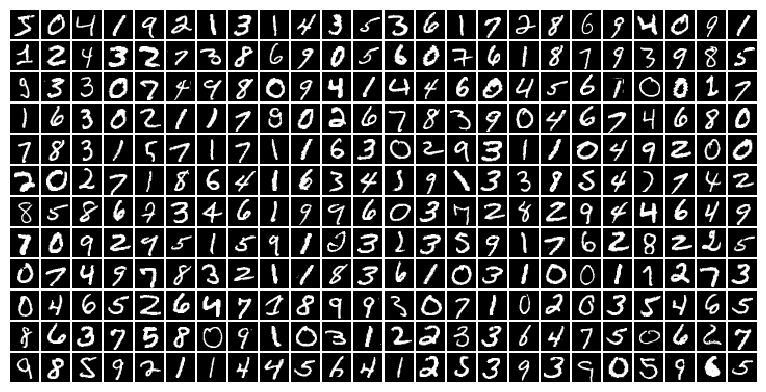

In [7]:
from mnists import MNIST

mnist = MNIST()
digits = mnist.train_images()
digits = digits[: 12 * 24]
digits = digits.reshape(-1, 24, 28, 28)
tiles(digits)

In [8]:
# Training set
X_train = mnist.train_images().astype(np.float32) / 255.0
X_train = X_train.reshape(-1, 28 * 28)
y_train = mnist.train_labels()
y_train = onehot(y_train)

size = 60_000
X_train = X_train[:size, ...]
y_train = y_train[:size, ...]

permutation = np.random.permutation(len(X_train))
X_train = X_train[permutation, ...]
y_train = y_train[permutation, ...]

# Test set
X_test = mnist.test_images().astype(np.float32) / 255.0
X_test = X_test.reshape(-1, 28 * 28)
y_test = mnist.test_labels()

Define MLP model

In [9]:
model = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(vsize=784, hsize=512, init_method="He"),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(vsize=512, hsize=512, init_method="He"),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(vsize=512, hsize=10, init_method="He"),
)

Run training

In [13]:
from math import ceil
from tqdm import trange

batch_size = 128
num_epochs = 50

model.reset()

optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in (pbar := trange(num_epochs)):
    dataloader = zip(chunks(X_train, batch_size), chunks(y_train, batch_size))
    total = ceil(len(X_train) / batch_size)

    # Training phase
    for X_batch, y_batch in dataloader:
        # Forward pass
        logits = model.forward(X_batch, training=True)

        # Compute gradient of the loss function w.r.t. the outputs of the network, assuming that the
        # loss function is the cross entropy
        grad_y = 1 / len(X_batch) * (softmax(logits) - y_batch)

        # Backward pass (compute gradients)
        model.backward(grad_y)

        # Update parameters
        optimizer.apply(model.gradients())

    # Validation phase
    logits = model.forward(X_test, training=False)
    accuracy = 1 / len(y_test) * np.sum(np.argmax(logits, axis=1) == y_test)

    # Log progress
    pbar.set_description(f"Epoch {epoch+1:>3d} | Accuracy {accuracy:>2.2%} |")

Epoch  50 | Accuracy 98.64% |: 100%|██████████| 50/50 [06:18<00:00,  7.58s/it]


Plot filters

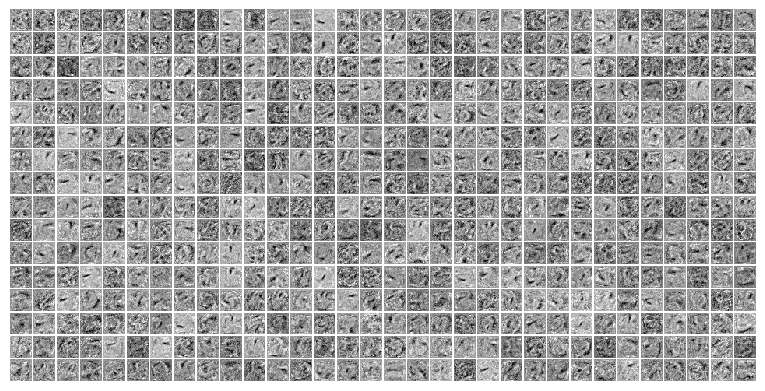

In [14]:
layer: nn.Linear = next(filter(lambda l: isinstance(l, nn.Linear), model.layers))
filters = layer.w.T
tiles(filters.reshape(16, -1, 28, 28))